In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from typing import Optional,Iterable
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.nn.functional import one_hot as f_one_hot
from torch.utils.data import TensorDataset, DataLoader

import torchvision.transforms as transforms 
from torchvision.datasets import MNIST
from sklearn import metrics

In [ ]:
def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def normalizing(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

def compute_confusion_matrix(target, pred, normalize=None, n_labels=2):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        labels=list(range(n_labels)),
        normalize=normalize,
    )

def pkernel_loss(y_pred: torch.Tensor, loss: torch.nn.Module) -> torch.Tensor:
    total_loss = 0.
    B = y_pred.shape[0]
    n_classes = y_pred.shape[-1]
    for i in range(n_classes):
        y_target = torch.zeros_like(y_pred).scatter(1, torch.tensor([i], dtype=torch.long, device=y_pred.device).repeat(B).unsqueeze(1), 1)
        total_loss += loss(y_pred.float(), y_target)
    total_loss = total_loss / n_classes**0.5
    return total_loss

def get_gradient(model: torch.nn.Module, x: torch.Tensor, loss_fn: callable, opt: torch.optim.Optimizer, flatten: bool = False, use_label: bool = False, y: Optional[torch.Tensor] = None) -> torch.Tensor:
    """
    Get the gradient of each element of the batch in x of the model with respect to the loss function
    
    Args:
        model: the model to use
        x: the input data [N_samples, ...]
        y: the target data [N_samples, ...]
        loss_fn: the loss function to use
        opt: the optimizer to use
        positive: whether to perturb the loss function positively or negatively
        kernel: What type of kernel to use, can either be pKernel, direct or average
        
    Returns:
        grads: the gradients of the model with respect to the loss function
    """
    B = len(x)
    device = next(model.parameters()).device
    x = x.to(device)
    if y is not None:
        y = y.to(device).float()
    opt.zero_grad()
    y_pred = model(x)
    if use_label:
        y_target = y
    else:
        y_target = y_pred.detach().argmax(1)
        y_target = torch.zeros_like(y_pred).scatter(1, y_target.unsqueeze(1), 1)
       
    loss = pkernel_loss(y_pred, loss_fn)
    # print(loss)
    # Trick to get gradient with respect to each sample in parallel
    grads = torch.autograd.grad(loss, model.parameters(), is_grads_batched=True, grad_outputs=torch.eye(B).to(device))
    if flatten:
        grads = torch.cat([grad.view((B, -1)) for grad in grads], -1)
    return grads

class own_linear_layer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(own_linear_layer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.beta = 0.1
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
        
    def reset_parameters(self):
        # Initialize the weights to normal distribution
        nn.init.normal_(self.weight, mean=0.0, std=1.0)
        if self.bias is not None:
            nn.init.normal_(self.bias, mean=0.0, std=1.0)
    
    def forward(self, x):
        return x @ self.weight.t()/(self.weight.shape[-1]**0.5) + self.beta*self.bias

class SingleLayerMLP(nn.Module):
    """ A simple single hidden-layer perceptron for MNIST classification """
    def __init__(self, input_size: int, output_size: int, hidden_size: int, num_layers: int = 1):
        super(SingleLayerMLP, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        # Define layers
        self.layers = nn.ModuleList()
        self.layers.append(own_linear_layer(input_size, hidden_size))
        self.layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            self.layers.append(own_linear_layer(hidden_size, hidden_size))
            self.layers.append(nn.ReLU())
        self.layers.append(own_linear_layer(hidden_size, output_size))
        
        # Initialize weights
        for layer in self.layers:
            if isinstance(layer, own_linear_layer):
                layer.reset_parameters()
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten input
        x = x.view(-1, self.input_size)
        
        # Forward pass
        for layer in self.layers:
            x = layer(x)
        return x
    
    def get_weights(self):
        return [layer.weight for layer in self.layers if isinstance(layer, own_linear_layer)]
    
    def get_biases(self):
        return [layer.bias for layer in self.layers if isinstance(layer, own_linear_layer)]
    
    def set_weights(self, weights, biases, initial_gain):
        i = 0
        for layer in self.layers:
            if isinstance(layer, own_linear_layer):
                weight = weights[i]
                bias = biases[i]
                in_features = layer.in_features
                out_features = layer.out_features
                k_factor = initial_gain
                layer.weight.data = weight.data[:out_features, :in_features]*k_factor
                layer.bias.data = bias.data[:out_features]*k_factor
                i += 1
    

class GaussianFit(torch.nn.Module):
    def __init__(self, model: torch.nn.Module, classes, device: torch.device, kernel_method: str = "direct", noise_var: float = 0.0):
        super(GaussianFit, self).__init__()
        self.device = device
        self.model = model
        self.kernel_method = kernel_method
        self.noise_var = noise_var
        self.covariance_matrix = None
        self.optimizer = None
        self.classes = classes
        
    def fit(self, data: Iterable[torch.Tensor], optimizer: torch.optim.Optimizer, loss_batched: torch.nn.Module):
        self.optimizer = optimizer
        self.loss = loss_batched
        xs, ys, y_hats = [], [], []
        with torch.no_grad():
            for x, y in data:
                xs.append(x)
                ys.append(y)
                y_hats.append(self.model(x.to(self.device)))
        xs    = torch.cat(xs, 0).to(self.device)
        y     = torch.cat(ys, 0).to(self.device)
        y_hat = torch.cat(y_hats, 0).to(self.device)
        self.label_diff = f_one_hot(y[:,-1],self.classes) - y_hat
        self.grads = get_gradient(self.model, xs, loss_batched, self.optimizer, True, True, y=y)
        self.update_w()
        
    def update_noise(self, noise_var: float):
        self.noise_var = noise_var
        self.update_w()
        
    def update_w(self):
        self.covarinace_kernel = self.grads@self.grads.T
        self.covariance_matrix = self.covarinace_kernel.clone()
        self.covariance_matrix[range(self.covariance_matrix.shape[0]), range(self.covariance_matrix.shape[0])] += self.noise_var
        self.W = torch.linalg.solve(self.covariance_matrix, self.label_diff).to(self.device)
        
    def encode_x(self, x: torch.Tensor) -> torch.Tensor:
        """ Function transforming input x into the gradient kernel space """
        x_grad = get_gradient(self.model, x, self.loss, self.optimizer, True, True)
        return x_grad @ self.grads.T
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x_grad = get_gradient(self.model, x, self.loss, self.optimizer, True, True)
        K_xX = x_grad@self.grads.T
        with torch.no_grad():
            y_hat = self.model(x)
        return y_hat + K_xX @ self.W
 
def MSELoss_batch(y_hat, y):
    return 0.5*(y_hat-y).pow(2).sum(-1)

def NTK_model(model, data, noise_var: float = 0.0):
    gradient_loader = data["gradient_loader"]
    device          = data["device"]
    classes         = data["classes"]
    optimizer    = torch.optim.SGD(model.parameters(), lr=0, momentum=0.9)
    kernel_model = GaussianFit(model, classes, device, noise_var=noise_var)
    kernel_model.fit(gradient_loader, optimizer, MSELoss_batch)
    # kernel_model.fit(gradient_loader, optimizer, nn.CrossEntropyLoss(reduction="none"))
    
    return kernel_model


In [4]:
# data
train_set = MNIST("../../3_Feedforward_PyTorch/temp/", train=True,  download=False, transform=transforms.ToTensor())
test_set  = MNIST("../../3_Feedforward_PyTorch/temp/", train=False, download=False, transform=transforms.ToTensor())
batch_size = 64 # both for training and testing

# # use only 1000 train and 1000 test
train_loader = DataLoader([(train_set.data[i].float()/255, train_set.targets[i,None]) for i in range(1000)], batch_size=batch_size, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader([( test_set.data[i].float()/255,  test_set.targets[i,None]) for i in range(5000)], batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

#--- Limit for testing ---
# train_label_size = 600
# test_label_size  = 300
# train_ta = train_set.data[train_set.targets == 0][:train_label_size].float()
# train_tb = train_set.data[train_set.targets == 1][:train_label_size].float()

# train_la = train_set.targets[train_set.targets == 0][:train_label_size]
# train_lb = train_set.targets[train_set.targets == 1][:train_label_size]
# train_la[:] = 0
# train_lb[:] = 1

# x_train = torch.cat((train_ta,train_tb))
# y_train = torch.cat((train_la,train_lb))

# # test
# test_ta = test_set.data[test_set.targets == 0][:test_label_size].float()
# test_tb = test_set.data[test_set.targets == 1][:test_label_size].float()

# test_la = test_set.targets[test_set.targets == 0][:test_label_size]
# test_lb = test_set.targets[test_set.targets == 1][:test_label_size]
# test_la[:] = 0
# test_lb[:] = 1

# x_test = torch.cat((test_ta,test_tb))
# y_test = torch.cat((test_la,test_lb))

# train_loader = DataLoader([(x_train[i].float()/255, y_train[i, None]) for i in range(train_label_size)], batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
# test_loader  = DataLoader([(x_test[i].float()/255,  y_test[i, None])  for i in range(test_label_size)], batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
#--- Limit for testing ---

# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
images, labels = next(iter(train_loader))
img = images.detach().cpu()

# # create empty canvas
# canvas = np.zeros((dim*2, 8*dim))

# # fill with tensors
# for i in range(2):
#     for j in range(8):
#         canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = img[idx].reshape((dim, dim))
#         idx += 1

# # visualize matrix of tensors as gray scale image
# plt.figure(figsize=(4, 4))
# plt.axis('off')
# plt.imshow(canvas, cmap='gray')
# plt.title('MNIST handwritten digits')
# plt.show()
# print(len(train_loader.dataset),len(test_loader.dataset))
# print(images[0].size(),labels.size())

# fig,ax = plt.subplots(2,8,figsize=(20,6))
# ax = ax.flat
# for i in range(len(ax)):
#     ax[i].imshow(img[i], cmap="gray")
#     ax[i].set_title(labels[i].item())
#     ax[i].axis("off")
# plt.show()

In [6]:
N_training = len(train_loader.dataset)
N_testing  = len(test_loader.dataset)

# Construct NN_model
n_in = dim**2
n_out = classes
n_hidden = 2*512 # 64*128
model_arch = SingleLayerMLP
criterion = lambda x, y: ((x-y)**2).mean()  # We need L2 loss for NTK
train_model = model_arch(n_in, n_out, n_hidden, num_layers=1)
optimizer = torch.optim.SGD(train_model.parameters(), lr=1.00, momentum=0.9)
CELoss    = nn.CrossEntropyLoss()


if torch.cuda.is_available(): device = torch.device('cuda')  
else:                         device = torch.device('cpu')
# device = torch.device('cpu')
print("Device:",device)
train_model.to(device)
print(train_model)

data = {
    "N_training"      : N_training,
    "N_testing"       : N_testing,
    "n_in"            : n_in,
    "n_out"           : n_out,
    "n_hidden"        : n_hidden,
    "gradient_loader" : train_loader,
    "device"          : device,
    "classes"         : classes,
}

Device: cuda
SingleLayerMLP(
  (layers): ModuleList(
    (0): own_linear_layer()
    (1): ReLU()
    (2): own_linear_layer()
  )
)


In [4]:
# data
train_set = MNIST("../../3_Feedforward_PyTorch/temp/", train=True,  download=False, transform=transforms.ToTensor())
test_set  = MNIST("../../3_Feedforward_PyTorch/temp/", train=False, download=False, transform=transforms.ToTensor())
batch_size = 64 # both for training and testing

# # use only 1000 train and 1000 test
train_loader = DataLoader([(train_set.data[i].float()/255, train_set.targets[i,None]) for i in range(1000)], batch_size=batch_size, shuffle=True,  num_workers=0, drop_last=False)
test_loader  = DataLoader([( test_set.data[i].float()/255,  test_set.targets[i,None]) for i in range(5000)], batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

#--- Limit for testing ---
# train_label_size = 600
# test_label_size  = 300
# train_ta = train_set.data[train_set.targets == 0][:train_label_size].float()
# train_tb = train_set.data[train_set.targets == 1][:train_label_size].float()

# train_la = train_set.targets[train_set.targets == 0][:train_label_size]
# train_lb = train_set.targets[train_set.targets == 1][:train_label_size]
# train_la[:] = 0
# train_lb[:] = 1

# x_train = torch.cat((train_ta,train_tb))
# y_train = torch.cat((train_la,train_lb))

# # test
# test_ta = test_set.data[test_set.targets == 0][:test_label_size].float()
# test_tb = test_set.data[test_set.targets == 1][:test_label_size].float()

# test_la = test_set.targets[test_set.targets == 0][:test_label_size]
# test_lb = test_set.targets[test_set.targets == 1][:test_label_size]
# test_la[:] = 0
# test_lb[:] = 1

# x_test = torch.cat((test_ta,test_tb))
# y_test = torch.cat((test_la,test_lb))

# train_loader = DataLoader([(x_train[i].float()/255, y_train[i, None]) for i in range(train_label_size)], batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
# test_loader  = DataLoader([(x_test[i].float()/255,  y_test[i, None])  for i in range(test_label_size)], batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)
#--- Limit for testing ---

# plot a few MNIST examples
idx, dim, classes = 0, 28, 10
images, labels = next(iter(train_loader))
img = images.detach().cpu()

# # create empty canvas
# canvas = np.zeros((dim*2, 8*dim))

# # fill with tensors
# for i in range(2):
#     for j in range(8):
#         canvas[i*dim:(i+1)*dim, j*dim:(j+1)*dim] = img[idx].reshape((dim, dim))
#         idx += 1

# # visualize matrix of tensors as gray scale image
# plt.figure(figsize=(4, 4))
# plt.axis('off')
# plt.imshow(canvas, cmap='gray')
# plt.title('MNIST handwritten digits')
# plt.show()
# print(len(train_loader.dataset),len(test_loader.dataset))
# print(images[0].size(),labels.size())

# fig,ax = plt.subplots(2,8,figsize=(20,6))
# ax = ax.flat
# for i in range(len(ax)):
#     ax[i].imshow(img[i], cmap="gray")
#     ax[i].set_title(labels[i].item())
#     ax[i].axis("off")
# plt.show()

In [ ]:
epochs = 100
# Train network to compare decision boundaries 

train_model.train()
train_loss = []
valid_loss = []
valid_acc  = []
for i in (pbar := tqdm(range(epochs))):
    train_loss_batches = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        
        output = train_model(inputs)
        loss = CELoss(output, targets[:,-1])
        # loss = ((output - f_one_hot(targets[:,-1],classes).float())**2).mean() / 2
        
        loss.backward()
        optimizer.step()
        
        predictions = output.max(1)[1]
        train_loss_batches.append(loss.detach().cpu())
    train_loss.append(np.mean(train_loss_batches))
    
    # Compute accuracies on validation set.
    valid_loss_batches = []
    valid_acc_batches = []
    with torch.no_grad():
        train_model.eval()
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = train_model(inputs)
            
            loss        = CELoss(output, targets[:,-1])
            # loss = ((output - f_one_hot(targets[:,-1],classes).float())**2).mean() / 2
            predictions = output.max(1)[1]

            # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
            valid_loss_batches.append(loss.cpu())
            valid_acc_batches.append(accuracy(targets, predictions))

        train_model.train()

    valid_loss.append(np.mean(valid_loss_batches))
    valid_acc.append(np.mean(valid_acc_batches))
print(round(valid_acc[-1]*100,2))

# NTK model
NTK_valid_loss_batches = []
NTK_valid_acc_batches  = []
kernel_model = NTK_model(train_model, data)
kernel_model.eval()
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    output = kernel_model.forward(inputs)
    
    predictions = output.max(1)[1]
    NTK_valid_acc_batches.append(accuracy(targets, predictions))


print(round(np.mean(NTK_valid_acc_batches)*100,2))


  0%|          | 0/100 [00:00<?, ?it/s]

83.31
83.83


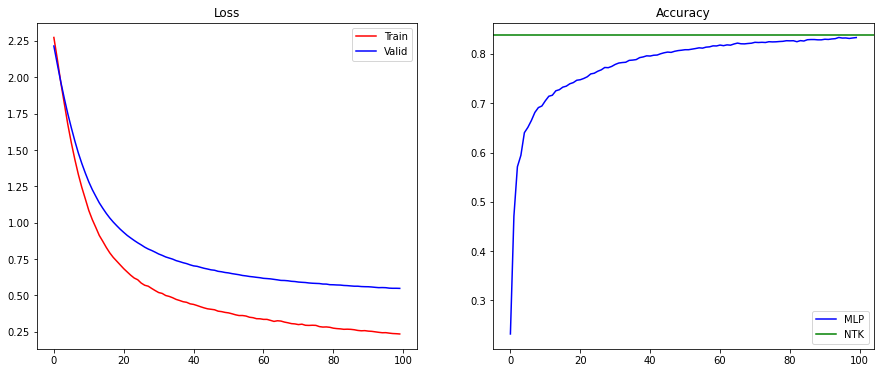

In [8]:
fig,ax = plt.subplots(1,2,figsize=(15,6))

ax[0].plot(train_loss, c="red" , label="Train")
ax[0].plot(valid_loss, c="blue", label="Valid")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(valid_acc, c="blue", label="MLP")
ax[1].axhline(np.mean(NTK_valid_acc_batches), c="green", label="NTK")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

In [9]:
# train model
train_confusion_matrix = np.zeros((classes, classes))
with torch.no_grad():
    train_model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = train_model(inputs)
        loss = ((output - targets.float())**2).mean()

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions))
        
        train_confusion_matrix += compute_confusion_matrix(targets, predictions,n_labels=classes)

    test_accuracy = np.mean(test_accuracies)
    
    train_model.train()
print(f"Train model: Test accuracy: {test_accuracy*100:.1f}%")

# NTK model
NTK_confusion_matrix = np.zeros((classes, classes))
# with torch.no_grad(): # requires grad
kernel_model.eval()
test_accuracies = []
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    output = kernel_model(inputs)
    loss = ((output - targets.float())**2).mean()

    predictions = output.max(1)[1]

    # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
    test_accuracies.append(accuracy(targets, predictions))
    
    NTK_confusion_matrix += compute_confusion_matrix(targets, predictions,n_labels=classes)

test_accuracy = np.mean(test_accuracies)

kernel_model.train()
print(f"  NTK model: Test accuracy: {test_accuracy*100:.1f}%")

Train model: Test accuracy: 83.3%
  NTK model: Test accuracy: 83.8%


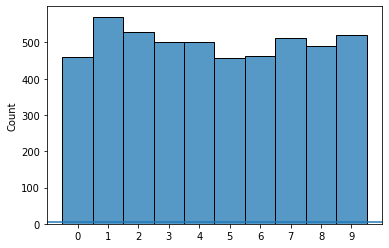

In [ ]:
sns.histplot(test_set.targets[:5000], discrete=True)
plt.axhline()
plt.xticks(range(10))
plt.show()

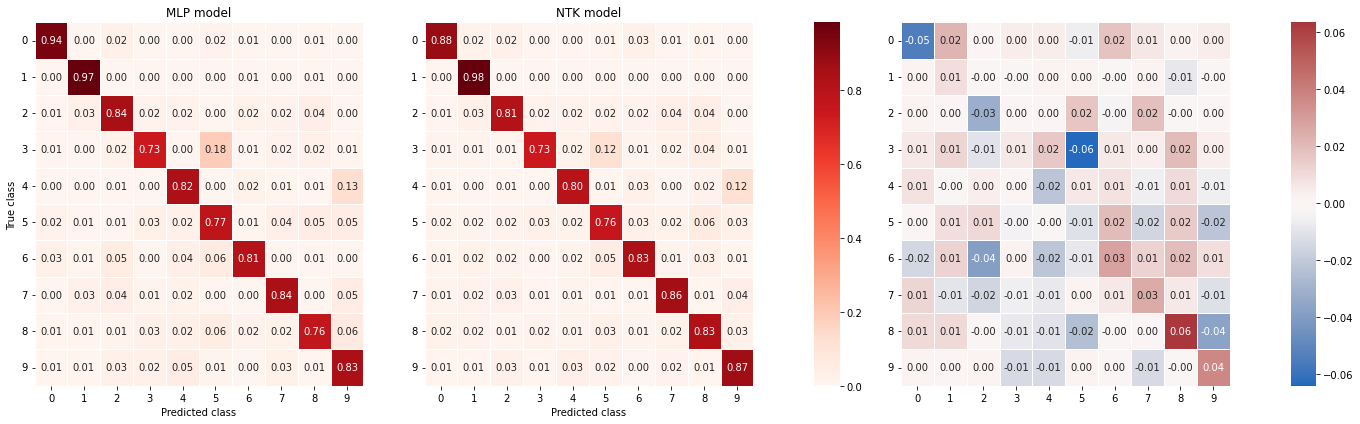

In [20]:
x_labels = list(range(classes))
y_labels = x_labels
fig,ax = plt.subplots(1,5,figsize=(19,6),width_ratios=[13, 13,1,13,1])
sns.heatmap(
    ax=ax[0],
    data=normalizing(train_confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
sns.heatmap(
    ax=ax[1],
    data=normalizing(NTK_confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=True,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
    cbar_ax=ax[2],
)
sns.heatmap(
    ax=ax[3],
    data=normalizing(NTK_confusion_matrix,"true")-normalizing(train_confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="vlag",
    cbar=True,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
    cbar_ax=ax[4],
)
# plt.xticks(rotation=90)
ax[0].set_title("MLP model")
ax[1].set_title("NTK model")
ax[0].tick_params(labelrotation=0)
ax[1].tick_params(labelrotation=0)
ax[3].tick_params(labelrotation=0)
ax[0].set_ylabel("True class")
ax[1].set_ylabel(" ")
ax[2].set_ylabel(" ")
ax[0].set_xlabel("Predicted class")
ax[1].set_xlabel("Predicted class")
plt.tight_layout()
plt.show()